In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Data Import

In [ ]:
train_x = pd.read_csv('/kaggle/input/new-data-upload/train_x.csv')
train_y = pd.read_csv('/kaggle/input/new-data-upload/train_y.csv')
train_data = train_x.join(train_y)

In [ ]:
val_x = pd.read_csv('/kaggle/input/new-data-upload/val_x.csv')
val_y = pd.read_csv('/kaggle/input/new-data-upload/val_y.csv')
val_data = val_x.join(val_y)

#### Column to predict

In [ ]:
attributes = ['y']

### RoBERTa Tokenizer from HuggingFace Transformers library

- Unitary released a RoBERTa language model, which was finetuned for their detoxify application. 
- As the encodings of this model captures semantic meaning of the comments, this is useful for our main task of making the comment classification unbiased.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("unitary/unbiased-toxic-roberta")

tokenizer_config.json:   0%|          | 0.00/997 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset
import torch

#### From EDA we found out that 80% of the comments length range below 128. So choosing this as our max length parameter. Also, this speeds up the finetuning process. 

In [ ]:
class Comment_Dataset(Dataset):
    def __init__(self, data, tokenizer, attributes, max_len: int = 128):
        
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.attributes = attributes
        
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        
        item = self.data.iloc[idx]
        comment = str(item.string)
        attributes = torch.FloatTensor(item[self.attributes])
        
        tokens = self.tokenizer.encode_plus(
            
            comment,
            add_special_tokens = True,
            padding = 'max_length',
            return_attention_mask = True,
            truncation = True,
            return_tensors = 'pt',
            max_length = self.max_len
            
        )
        
        return tokens.input_ids.flatten(), tokens.attention_mask.flatten(), attributes
        

In [ ]:
train_ds = Comment_Dataset(train_data, tokenizer, attributes )
val_ds = Comment_Dataset(val_data, tokenizer, attributes )

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 64
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

### Used Focal Loss, which is an idea inspired from Computer vision applications. 

We chose to use this for our case of text classification as the class imbalance is severe. 

#### A Quick intro to Focal Loss (It's interesting!)

 - Focal loss focuses on the examples that the model gets wrong rather than the ones that it can confidently predict, ensuring that predictions on hard examples improve over time rather than becoming overly confident with easy ones.
 - **How exactly is this done?** Focal loss achieves this through something called *Down Weighting*. 
 - Down weighting is a technique that reduces the influence of easy examples on the loss function, resulting in more attention being paid to hard examples. This technique can be implemented by adding a modulating factor to the Cross-Entropy loss

$$
\text { Focal Loss }=-\sum_{i=1}^{i=n}(1-p)^\gamma \log (p)
$$

- More the value of γ, more importance will be given to misclassified examples and very less loss will be propagated from easy examples.

#### Let's see how Cross-Entropy and Focal Loss differ in our case

Let *p* be the probability of toxic class.

Formula for Cross-Entropy Loss Function simplifies to
1. -log(x) For positives
2. -log(1-x)  For negatives

**True Negative** - Non toxic comment classified as Non toxic (This is Easy example in our case as Non-Toxic examples are majority)

- *p* = 0.1, *(1-p)* = 0.9 
- CE = -log(0.9) --> 0.1054

- FL = (1-0.1)^2 * log(1-0.1) --> 0.0853


**False Negative** - Toxic comment classified as Non toxic (This is Hard Example as Toxic examples are in Minority)

- *p* = 0.1
- CE = -log(0.1) --> 2.302
- FL = (1-0.1)^2 * log(0.1) --> 1.865


- In the Easy example case we can see the Focal loss is significatly lower than Cross entropy where as in hard example Focal loss is not significatly different. Thus Focal loss downweighs the easy example and hence addressing the class imbalance problem to a certain degree

### Focal Loss implementation 

In [ ]:
from torch.nn import functional as F

class FocalLoss(nn.Module):
    def __init__(self,
                 gamma: float = 2,
                 reduction: str = "mean",
                 pos_weight: torch.Tensor = None):
        super(FocalLoss, self).__init__()
        self.gamma= gamma
        self.reduction = reduction
        self.pos_weight = pos_weight

    def forward(self, inputs: torch.Tensor,
                targets: torch.Tensor):
        p = torch.sigmoid(inputs)
        ce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, reduction="none", pos_weight=self.pos_weight
        )
        p_t =  p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

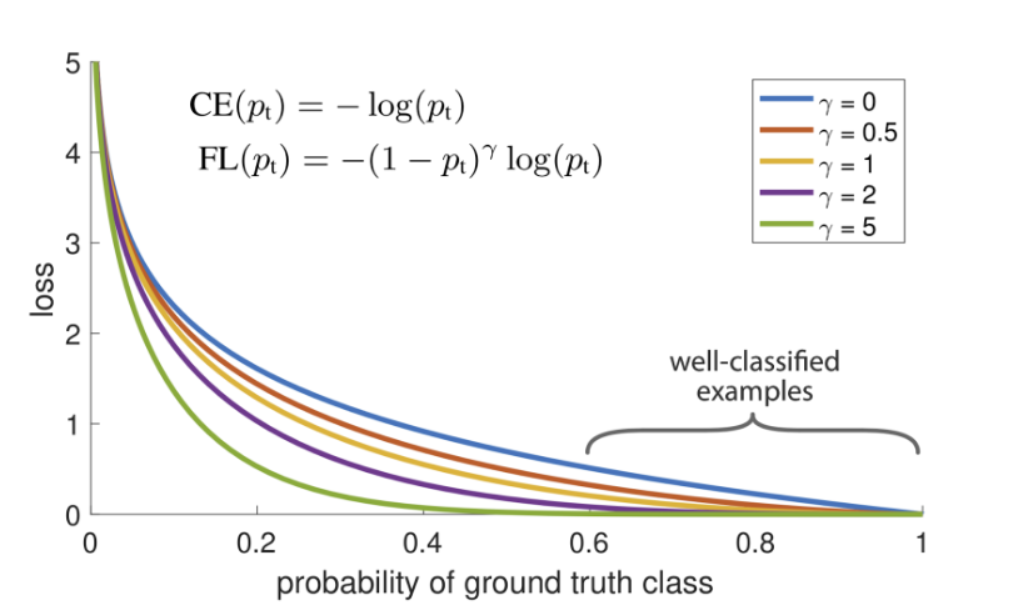

In [ ]:
import torch.nn as nn

In [ ]:
from transformers import AutoModel

class Comment_classifier(nn.Module):
    def __init__(self):
        super(Comment_classifier, self).__init__()
            
        self.pretrained_model = AutoModel.from_pretrained("unitary/unbiased-toxic-roberta")
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(768, 1)
        
    def forward(self, input_id, attention_mask, labels = None):
        
        
        x = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask, output_hidden_states=False)
        x = self.dropout(x[1])
        x = self.linear(x)
        
        return x
    
        
        

In [ ]:
pos_weight = torch.tensor([2.0]).to('cuda')
criterion = FocalLoss(gamma= 3, pos_weight= pos_weight).to('cuda')
criterion = FocalLoss().to('cuda')
lr = 1.5e-6
optimizer = torch.optim.Adam(params =  model.parameters(), lr=lr)
    

##### Function to calculate Worst Group Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

def worst_group_accuracy(prediction, y):
    """
        Compute the worst group accuracy, with the groups being defined by ['male', 'female', 'LGBTQ',
        'christian', 'muslim', 'other_religions', 'black', 'white'] for positive and negative toxicity.
        arguments:
            prediction [pandas.DataFrame]: dataframe with 2 columns (index and pred)
            y [pandas.DataFrame]: dataframe containing the metadata
        returns:
            wga [float]: worst group accuracy
    """
    y.loc[prediction.index, 'pred'] = prediction.pred

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies = []
    for category in categories:
        for label in [0, 1]:
            group = y.loc[y[category] == label]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            accuracies.append(group_accuracy)
    wga = np.min(accuracies)
    return wga, accuracies

In [ ]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)


In [ ]:
from tqdm import tqdm

wga_best = 0
epochs = 5
logs = {}
for epoch in range(epochs):
    
    model.train()
    total_loss = 0
    
    train_iterator = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}', dynamic_ncols=True)
    
    for batch in train_iterator:
        input_ids, attention_masks, labels = batch
        input_ids, attention_masks, labels = input_ids.to('cuda'), attention_masks.to('cuda'), labels.to('cuda').float()

        
        outputs = model(input_ids, attention_mask=attention_masks)
        
        loss = criterion(outputs, labels) #Class imbalance?
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update the tqdm progress bar
        train_iterator.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_dataloader)
        
    #Validation 
    
    model.eval()
    total_val_loss = 0
    all_predictions = []
    # Create a tqdm progress bar for the validation data
    val_iterator = tqdm(val_dataloader, desc='Validation', dynamic_ncols=True)
    
    with torch.no_grad():
        for batch in val_iterator:
            input_ids, attention_masks, labels = batch
            input_ids, attention_masks, labels = input_ids.to('cuda'), attention_masks.to('cuda'), labels.to('cuda').float()
            
            outputs = model(input_ids, attention_mask=attention_masks)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()
            
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            predicted_labels = (probs > 0.5).float()  # Convert probabilities to predicted class (0 or 1)

            all_predictions.append(predicted_labels.cpu().numpy())
            
            # Update the tqdm progress bar
            val_iterator.set_postfix(val_loss=val_loss / len(val_iterator))
            
        avg_val_loss = total_val_loss / len(val_dataloader)    
        all_predictions = np.concatenate(all_predictions, axis=0)
        true_labels = np.array(val_data[attributes])  
        accuracy = accuracy_score(true_labels, all_predictions)
        
        predictions_df = pd.DataFrame({
        'index': data_indices,  # This should align with the index of your 'y' DataFrame
        'pred': all_predictions.squeeze()  # Make sure this is a 1D array
            })
        
        wga, grp_acc = worst_group_accuracy(predictions_df, val_y)
        
        groups = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
        toxic_acc = grp_acc[::2]
        nontoxic_acc = grp_acc[1::2]

        # Create a DataFrame
        df = pd.DataFrame({'Identity': groups, 'Identity Not Present': toxic_acc, 'Identity Present': nontoxic_acc})
        
        
        if wga > wga_best:
            
            torch.save(model.state_dict(), 'roberta_finetuned_wga_fl_weighted.pt')
            wga_best = wga
            best_preds = predictions_df
            
        logs[epoch+1] = [val_loss / len(val_dataloader), accuracy, wga]
        
            
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.4f}, Val_loss: {avg_val_loss}, Validation Accuracy: {accuracy}%, WGA: {wga}, WGA_best: {wga_best}')
        print(df)

        
        

Validation: 100%|██████████| 706/706 [03:49<00:00,  3.08it/s, val_loss=tensor(0.0001, device='cuda:0')]    


Epoch [1/5], Train Loss: 0.0426, Val_loss: 0.03861188860567255, Validation Accuracy: 0.9412129260734838%, WGA: 0.8274818401937046, WGA_best: 0.8274818401937046
          Identity  Identity Not Present  Identity Present
0             male              0.943288          0.923610
1           female              0.943445          0.926328
2            LGBTQ              0.944354          0.846946
3        christian              0.940537          0.947253
4           muslim              0.944973          0.864455
5  other_religions              0.942187          0.897566
6            black              0.945529          0.827482
7            white              0.948763          0.829787


Validation: 100%|██████████| 706/706 [03:50<00:00,  3.07it/s, val_loss=tensor(9.4429e-05, device='cuda:0')]


Epoch [2/5], Train Loss: 0.0388, Val_loss: 0.037718207055964, Validation Accuracy: 0.9421868083222665%, WGA: 0.8274818401937046, WGA_best: 0.8274818401937046
          Identity  Identity Not Present  Identity Present
0             male              0.944402          0.923400
1           female              0.944539          0.926498
2            LGBTQ              0.945223          0.851064
3        christian              0.941595          0.947473
4           muslim              0.945739          0.869668
5  other_religions              0.943114          0.900609
6            black              0.946540          0.827482
7            white              0.949519          0.833973


Validation: 100%|██████████| 706/706 [03:44<00:00,  3.15it/s, val_loss=tensor(0.0001, device='cuda:0')]    


Epoch [3/5], Train Loss: 0.0371, Val_loss: 0.03812860265773557, Validation Accuracy: 0.9416555998229305%, WGA: 0.8329297820823245, WGA_best: 0.8329297820823245
          Identity  Identity Not Present  Identity Present
0             male              0.943857          0.922980
1           female              0.943903          0.926668
2            LGBTQ              0.944789          0.847632
3        christian              0.940906          0.948352
4           muslim              0.945136          0.870616
5  other_religions              0.942775          0.891481
6            black              0.945782          0.832930
7            white              0.948834          0.835717


Validation: 100%|██████████| 706/706 [03:49<00:00,  3.08it/s, val_loss=tensor(0.0001, device='cuda:0')]    


Epoch [4/5], Train Loss: 0.0359, Val_loss: 0.039035562438301336, Validation Accuracy: 0.9395750332005313%, WGA: 0.8207185211021975, WGA_best: 0.8329297820823245
          Identity  Identity Not Present  Identity Present
0             male              0.941730          0.921301
1           female              0.941918          0.923952
2            LGBTQ              0.942685          0.846259
3        christian              0.938715          0.947253
4           muslim              0.943418          0.861137
5  other_religions              0.940625          0.892495
6            black              0.943898          0.825666
7            white              0.947628          0.820719


Validation: 100%|██████████| 706/706 [03:47<00:00,  3.10it/s, val_loss=tensor(0.0001, device='cuda:0')]    


Epoch [5/5], Train Loss: 0.0346, Val_loss: 0.038265086021607414, Validation Accuracy: 0.9415891987605135%, WGA: 0.8341404358353511, WGA_best: 0.8341404358353511
          Identity  Identity Not Present  Identity Present
0             male              0.943486          0.925498
1           female              0.943776          0.927007
2            LGBTQ              0.944720          0.847632
3        christian              0.941004          0.946813
4           muslim              0.945345          0.864929
5  other_religions              0.942730          0.890467
6            black              0.945667          0.834140
7            white              0.948810          0.835019


#### Weighted Cross Entropy Loss

In [ ]:
identities = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']

In [ ]:
data = []

# Iterate through each identity
for identity in identities:
    # Calculate the count of toxic instances for this identity
    toxic_count = train_data[(train_data[identity] > 0.5) & (train_data['y'] == 1)].shape[0]
    
    # Calculate the count of non-toxic instances for this identity
    non_toxic_count = train_data[(train_data[identity] > 0.5) & (train_data['y'] == 0)].shape[0]
    
    total_count = train_data[(train_data[identity] > 0.5)].shape[0]
    
    # Append the counts to your data list
    data.append([identity, toxic_count, non_toxic_count, total_count])

# Create a DataFrame from your data
summary_df_train = pd.DataFrame(data, columns=['Identity', 'Toxic_Count', 'Non_Toxic_Count' , 'Total_Count'])
summary_df_train['difference'] = summary_df_train['Non_Toxic_Count'] - summary_df_train['Toxic_Count'] 
summary_df_train['difference_weight'] = summary_df_train['Total_Count']/summary_df_train['difference']

# Display the DataFrame
print(summary_df_train)

          Identity  Toxic_Count  Non_Toxic_Count  Total_Count  difference  \
0             male         4437            25373        29810       20936   
1           female         4962            31282        36244       26320   
2            LGBTQ         2265             6155         8420        3890   
3        christian         2446            24292        26738       21846   
4           muslim         3125            10829        13954        7704   
5  other_religions         1003             5541         6544        4538   
6            black         3111             6785         9896        3674   
7            white         4682            12016        16698        7334   

   difference_weight  
0           1.423863  
1           1.377052  
2           2.164524  
3           1.223931  
4           1.811267  
5           1.442045  
6           2.693522  
7           2.276793  


In [ ]:
summary_df_train

,Identity,Toxic_Count,Non_Toxic_Count,Total_Count,difference,difference_weight
0,male,4437,25373,29810,20936,1.423863
1,female,4962,31282,36244,26320,1.377052
2,LGBTQ,2265,6155,8420,3890,2.164524
3,christian,2446,24292,26738,21846,1.223931
4,muslim,3125,10829,13954,7704,1.811267
5,other_religions,1003,5541,6544,4538,1.442045
6,black,3111,6785,9896,3674,2.693522
7,white,4682,12016,16698,7334,2.276793


### Why did I choose the difference as a weigting factor? 

- When the model was trained on BCE Loss, for every identity group, it is observed that the False Negatives are more. 
- This is expected as the number of *Non-Toxic* examples are higher. Model can be biased to predict a Toxic example as Non-Toxic. 
- But, I observed a pattern in worst performing groups. If the difference in Non toxic and toxic examples in a group is smaller, the total accuracy for the group is lower. 
- A smaller difference indicates a relatively balanced dataset for that group, which might mean the model doesn't learn enough distinguishing features for the Toxic class due to fewer examples.
- From the table we can see that black, white, LGBTQ, and muslim are the groups with relative lowest difference. These were the groups in the exact order that were performing poorly. 
- So, weighing based on this idea made much more sense. 

In [ ]:
mask_male_toxic = (train_data['male'] > 0.5) & (train_data['y'] == 1)
mask_female_toxic = (train_data['female'] > 0.5) & (train_data['y'] == 1)
mask_LGBTQ_toxic = (train_data['LGBTQ'] > 0.5) & (train_data['y'] == 1)
mask_christian_toxic = (train_data['christian'] > 0.5) & (train_data['y'] == 1)
mask_muslim_toxic = (train_data['muslim'] > 0.5) & (train_data['y'] == 1)
mask_other_religions_toxic = (train_data['other_religions'] > 0.5) & (train_data['y'] == 1)
mask_black_toxic = (train_data['black'] > 0.5) & (train_data['y'] == 1)
mask_white_toxic = (train_data['white'] > 0.5) & (train_data['y'] == 1)

In [ ]:
summary_df = summary_df_train

Adding weights to toxic examples of worst performing groups

In [ ]:
train_data['weights'] = 1
train_data.loc[mask_LGBTQ_toxic, 'weights'] += summary_df[summary_df['Identity'] == 'LGBTQ']['difference_weight'].values[0]
train_data.loc[mask_muslim_toxic, 'weights'] += summary_df[summary_df['Identity'] == 'muslim']['difference_weight'].values[0]
train_data.loc[mask_black_toxic, 'weights'] += (summary_df[summary_df['Identity'] == 'black']['difference_weight'].values[0])*2
train_data.loc[mask_white_toxic, 'weights'] += (summary_df[summary_df['Identity'] == 'white']['difference_weight'].values[0])*2

In [ ]:
val_data['weights'] = 1

In [ ]:
class Comment_Dataset(Dataset):
    def __init__(self, data, tokenizer, weights, attributes, max_len: int = 128):
        
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.attributes = attributes
        self.weights = weights
        
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        
        item = self.data.iloc[idx]
        comment = str(item.string)
        attributes = torch.FloatTensor(item[self.attributes])
        weights = torch.tensor(self.weights.iloc[idx], dtype = torch.float)
        
        tokens = self.tokenizer.encode_plus(
            
            comment,
            add_special_tokens = True,
            padding = 'max_length',
            return_attention_mask = True,
            truncation = True,
            return_tensors = 'pt',
            max_length = self.max_len
            
        )
        
        return tokens.input_ids.flatten(), tokens.attention_mask.flatten(), attributes, weights
        

In [ ]:
train_ds = Comment_Dataset(train_data, tokenizer,attributes = attributes, weights = train_data['weights'] )
val_ds = Comment_Dataset(val_data, tokenizer, attributes = attributes,weights= val_data['weights'] )

In [ ]:
batch_size = 32
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
from transformers import AutoModel

class Comment_classifier(nn.Module):
    def __init__(self):
        super(Comment_classifier, self).__init__()
            
        self.pretrained_model = AutoModel.from_pretrained("unitary/unbiased-toxic-roberta")
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(768, 1)
        
    def forward(self, input_id, attention_mask, labels = None):
        
        
        x = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask, output_hidden_states=False)
        x = self.dropout(x[1])
        x = self.linear(x)
        
        return x
    
        
        

In [ ]:
model = Comment_classifier().to('cuda')

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at unitary/unbiased-toxic-roberta and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 1.5e-6
optimizer = torch.optim.Adam(params =  model.parameters(), lr=lr)
    

In [ ]:
from tqdm import tqdm

wga_best = 0
epochs = 5
logs = {}
for epoch in range(epochs):
    
    model.train()
    total_loss = 0
    
    train_iterator = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{epochs}', dynamic_ncols=True)
    
    for batch in train_iterator:
        input_ids, attention_masks, labels, weights = batch
        input_ids, attention_masks, labels, weights = input_ids.to('cuda'), attention_masks.to('cuda'), labels.to('cuda').float(), weights.to('cuda')

        
        outputs = model(input_ids, attention_mask=attention_masks)
        
        
        loss = (F.binary_cross_entropy_with_logits(outputs, labels, reduction='none') * weights ).mean()
        
        #loss = criterion(outputs, labels) #Class imbalance?
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Update the tqdm progress bar
        train_iterator.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_dataloader)
        
    #Validation 
    
    model.eval()
    total_val_loss = 0
    all_predictions = []
    # Create a tqdm progress bar for the validation data
    val_iterator = tqdm(val_dataloader, desc='Validation', dynamic_ncols=True)
    
    with torch.no_grad():
        for batch in val_iterator:
            input_ids, attention_masks, labels, weights = batch
            input_ids, attention_masks, labels, weights = input_ids.to('cuda'), attention_masks.to('cuda'), labels.to('cuda').float(), weights.to('cuda')
            
            outputs = model(input_ids, attention_mask=attention_masks)
            val_loss = (F.binary_cross_entropy_with_logits(outputs, labels, reduction='none') ).mean()
            #val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()
            
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            predicted_labels = (probs > 0.5).float()  # Convert probabilities to predicted class (0 or 1)

            all_predictions.append(predicted_labels.cpu().numpy())
            
            # Update the tqdm progress bar
            val_iterator.set_postfix(val_loss=val_loss / len(val_iterator))
            
        avg_val_loss = total_val_loss / len(val_dataloader)    
        all_predictions = np.concatenate(all_predictions, axis=0)
        true_labels = np.array(val_data[attributes])  
        accuracy = accuracy_score(true_labels, all_predictions)
        
        predictions_df = pd.DataFrame({
        'index': data_indices,  # This should align with the index of your 'y' DataFrame
        'pred': all_predictions.squeeze()  # Make sure this is a 1D array
            })
        
        wga, grp_acc = worst_group_accuracy(predictions_df, val_y)
        
        groups = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
        toxic_acc = grp_acc[::2]
        nontoxic_acc = grp_acc[1::2]

        # Create a DataFrame
        df = pd.DataFrame({'Identity': groups, 'Identity Not Present': toxic_acc, 'Identity Present': nontoxic_acc})
        
        
        if wga > wga_best:
            
            torch.save(model.state_dict(), 'roberta_finetuned_wga_fl.pt')
            wga_best = wga
            best_preds = predictions_df
            
        logs[epoch+1] = [val_loss / len(val_dataloader), accuracy, wga]
        
            
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.4f}, Val_loss: {avg_val_loss}, Validation Accuracy: {accuracy}%, WGA: {wga}, WGA_best: {wga_best}')
        print(df)

        
        

Validation: 100%|██████████| 1412/1412 [03:39<00:00,  6.42it/s, val_loss=tensor(0.0001, device='cuda:0')]    


Epoch [1/5], Train Loss: 0.2344, Val_loss: 0.14433656937888595, Validation Accuracy: 0.9412350597609562%, WGA: 0.8244552058111381, WGA_best: 0.8244552058111381
          Identity  Identity Not Present  Identity Present
0             male              0.943214          0.924449
1           female              0.943496          0.926159
2            LGBTQ              0.944331          0.848318
3        christian              0.940610          0.946813
4           muslim              0.945113          0.862085
5  other_religions              0.942164          0.899594
6            black              0.945667          0.824455
7            white              0.948692          0.831182


Validation: 100%|██████████| 1412/1412 [03:40<00:00,  6.41it/s, val_loss=tensor(0.0001, device='cuda:0')]    


Epoch [2/5], Train Loss: 0.2084, Val_loss: 0.14231986646367653, Validation Accuracy: 0.9420097388224878%, WGA: 0.8292978208232445, WGA_best: 0.8292978208232445
          Identity  Identity Not Present  Identity Present
0             male              0.944402          0.921721
1           female              0.944488          0.925480
2            LGBTQ              0.944972          0.853123
3        christian              0.941275          0.948571
4           muslim              0.945623          0.868246
5  other_religions              0.943024          0.896552
6            black              0.946287          0.829298
7            white              0.949425          0.832578


Validation: 100%|██████████| 1412/1412 [03:40<00:00,  6.42it/s, val_loss=tensor(0.0001, device='cuda:0')]    


Epoch [3/5], Train Loss: 0.1983, Val_loss: 0.14141199192106915, Validation Accuracy: 0.9416555998229305%, WGA: 0.8299031476997578, WGA_best: 0.8299031476997578
          Identity  Identity Not Present  Identity Present
0             male              0.943907          0.922560
1           female              0.944005          0.925989
2            LGBTQ              0.944926          0.843514
3        christian              0.940980          0.947692
4           muslim              0.945438          0.864455
5  other_religions              0.942707          0.894523
6            black              0.945897          0.829903
7            white              0.949046          0.832578


Validation: 100%|██████████| 1412/1412 [03:42<00:00,  6.33it/s, val_loss=tensor(0.0001, device='cuda:0')]    


Epoch [4/5], Train Loss: 0.1904, Val_loss: 0.14329842465467818, Validation Accuracy: 0.9419654714475432%, WGA: 0.8286924939467313, WGA_best: 0.8299031476997578
          Identity  Identity Not Present  Identity Present
0             male              0.944501          0.920462
1           female              0.944463          0.925310
2            LGBTQ              0.945040          0.849691
3        christian              0.941226          0.948571
4           muslim              0.945438          0.871090
5  other_religions              0.942956          0.897566
6            black              0.946264          0.828692
7            white              0.949283          0.833973


Epoch 5/5:  19%|█▉        | 1626/8408 [11:01<45:46,  2.47it/s, loss=0.169]  

#### Now that we have two of our best performing models, for kaggle submission let's try to ensemble them both.

##### Loading RoBERTa with Focal loss

In [ ]:
model.load_state_dict(torch.load('/kaggle/input/roberta-fl/roberta_finetuned_wga_83.25_fl.pt'))

<All keys matched successfully>

Test dataloader 

In [ ]:
test_data = pd.read_csv('/kaggle/input/new-data-upload/test_x.csv')

class Test_Dataset(Dataset):
    def __init__(self, data, tokenizer, max_len: int = 128):
        
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len
        
        
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        
        item = self.data.iloc[idx]
        comment = str(item.string)
        
        
        tokens = self.tokenizer.encode_plus(
            
            comment,
            add_special_tokens = True,
            padding = 'max_length',
            return_attention_mask = True,
            truncation = True,
            return_tensors = 'pt',
            max_length = self.max_len
            
        )
        
        input_ids = tokens.input_ids.flatten()
        attention_mask = tokens.attention_mask.flatten()
        
        # Ensure the input_ids and attention_mask are the correct length
        if len(input_ids) != self.max_len or len(attention_mask) != self.max_len:
            raise ValueError(f"Token length mismatch! Expected {self.max_len}, got {len(input_ids)}")

        return input_ids, attention_mask
    
test_ds = Test_Dataset(test_data, tokenizer)

test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle = False, pin_memory = True)

In [ ]:
from tqdm import tqdm

We are taking the Logits of predictions to ensemble our two best models

In [ ]:
model.eval()
test_predictions = []
with torch.no_grad():
    test_iterator = tqdm(test_dataloader, desc='Testing', dynamic_ncols=True)
    for batch in test_iterator:
        input_ids, attention_masks = batch
        input_ids, attention_masks = input_ids.to('cuda'), attention_masks.to('cuda')
            
        outputs = model(input_ids, attention_mask=attention_masks)

            
        #probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        #predicted_labels = (probs > 0.5).float()  # Convert probabilities to predicted class (0 or 1)

        test_predictions.append(outputs.cpu().numpy())
                
    test_predictions = np.concatenate(test_predictions, axis=0)
    

Testing: 100%|██████████| 2091/2091 [09:51<00:00,  3.53it/s]


In [ ]:
predictions_df_fl = pd.DataFrame({
        'index': list(test_data.index),  
        'pred': test_predictions.squeeze()  # Make sure this is a 1D array
            })

# Rename 'index' column to 'ID'
predictions_df_fl.rename(columns={'index': 'ID'}, inplace=True)

# Convert 'pred' column to int




In [ ]:
predictions_df_fl.to_csv('fl_logits_roberta.csv' , index = False)

##### Loading RoBERTa with weighted bce loss

In [ ]:
model.load_state_dict(torch.load('/kaggle/input/weighted-bce-roberta/roberta_finetuned_identitiy_weights.pt'))

<All keys matched successfully>

In [ ]:
model.eval()
test_predictions = []
with torch.no_grad():
    test_iterator = tqdm(test_dataloader, desc='Testing', dynamic_ncols=True)
    for batch in test_iterator:
        input_ids, attention_masks = batch
        input_ids, attention_masks = input_ids.to('cuda'), attention_masks.to('cuda')
            
        outputs = model(input_ids, attention_mask=attention_masks)

            
        #probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        #predicted_labels = (probs > 0.5).float()  # Convert probabilities to predicted class (0 or 1)

        test_predictions.append(outputs.cpu().numpy())
                
    test_predictions = np.concatenate(test_predictions, axis=0)
    

Testing: 100%|██████████| 2091/2091 [09:51<00:00,  3.53it/s]


In [ ]:
predictions_df_bce = pd.DataFrame({
        'index': list(test_data.index),  
        'pred': test_predictions.squeeze()  # Make sure this is a 1D array
            })

# Rename 'index' column to 'ID'
predictions_df_bce.rename(columns={'index': 'ID'}, inplace=True)

# Convert 'pred' column to int


predictions_df_bce.to_csv('bce_logits_roberta.csv' , index = False)

Ensemble both predictions

In [ ]:
predictions_df_fl['bce'] = predictions_df_bce['pred']

In [ ]:
predictions_df_fl

,ID,pred,bce
0,0,0.545769,0.996495
1,1,-3.509054,-6.349059
2,2,-2.447942,-4.022703
3,3,1.654691,3.834455
4,4,-3.394159,-6.259115
...,...,...,...
133777,133777,-0.656956,-1.698168
133778,133778,-0.585264,-2.599921
133779,133779,-1.088362,-2.644628
133780,133780,1.298331,3.950317


In [ ]:
predictions_df_fl['mean'] = 0.5*predictions_df_fl['pred'] + 0.5*predictions_df_fl['bce'] 

In [ ]:
predictions_df_fl['sigmoid'] = 1 / (1 + np.exp(-predictions_df_fl['mean']))

# Convert to labels
threshold = 0.5
predictions_df_fl['label'] = predictions_df_fl['sigmoid'].apply(lambda x: 1 if x > threshold else 0)

In [ ]:
predictions_df_fl

,ID,pred,bce,mean,sigmoid,label
0,0,0.545769,0.996495,0.771132,0.683766,1
1,1,-3.509054,-6.349059,-4.929056,0.007181,0
2,2,-2.447942,-4.022703,-3.235322,0.037858,0
3,3,1.654691,3.834455,2.744573,0.939606,1
4,4,-3.394159,-6.259115,-4.826637,0.007950,0
...,...,...,...,...,...,...
133777,133777,-0.656956,-1.698168,-1.177562,0.235491,0
133778,133778,-0.585264,-2.599921,-1.592592,0.169019,0
133779,133779,-1.088362,-2.644628,-1.866495,0.133948,0
133780,133780,1.298331,3.950317,2.624324,0.932411,1


In [ ]:
final_predictions = predictions_df_fl['label']

In [ ]:
# Reset the index to make the index into a column
final_predictions_df = final_predictions.reset_index()

# Rename the columns to 'index' and 'pred'
final_predictions_df.columns = ['ID', 'pred']

Submission

In [ ]:
final_predictions_df.to_csv('ensemble_preds_fl_bce.csv', index=False)

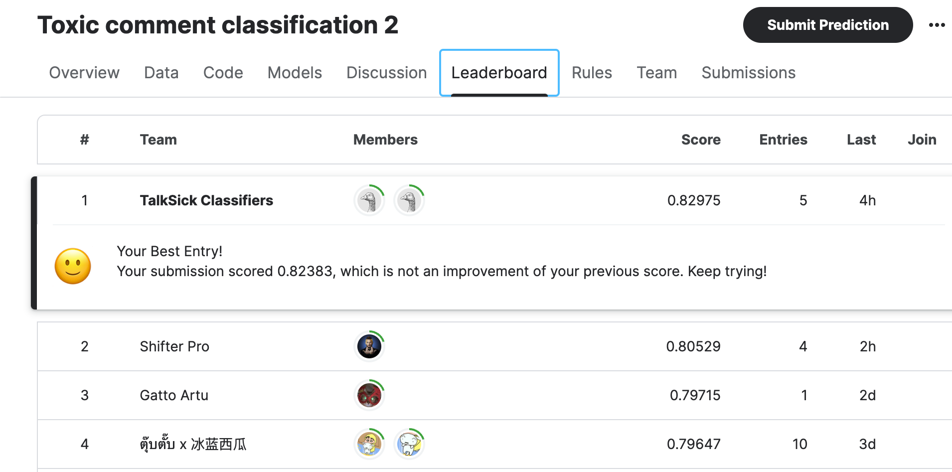

## Thoughts and further improvements

- As mentioned in the paper https://ieeexplore.ieee.org/document/8903313 I would try adding auxillary sentences to the BERT encoding. I can use auxiliary labels like 'insult', 'obscene', 'sexually explicit', and 'severe toxicity' to generate auxiliary sentences and feed them along with the main text to a BERT model during training. This approach can enhance the model's understanding of the nuances and specific types of toxicity present in the text.

- Since identifying the existing groups in the text using a BERT model is easier, I would try creating a seperate models for each of the worst performing groups and ensemble them for better predictions.

- Fairness by (un)awareness - Completely removing the sensitive information like identities from the training data

- Fairness Through Awareness -  Found this interesting work https://arxiv.org/pdf/1104.3913.pdf where they use a distance metric that defines the similarity between the individuals

- I would want to try other Large Language models like TinyLlama, Llama gaurd or the recent Llama 2